In [295]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tsa.seasonal import seasonal_decompose, DecomposeResult
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import seaborn as sns
import itertools
import scipy
from dtaidistance import dtw
from sklearn import metrics
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests
# suppress all warnings
import warnings
warnings.filterwarnings("ignore")

In [178]:
# set palette

palette = ['#56903A','#C56C39','#BAE5F9','#6F4930','#213A1B']
sns.set_palette(palette)

In [2]:
# read in the visitation data
visit_data = pd.read_csv('timeseries_data.csv',index_col='Unnamed: 0')
visit_data['date'] = pd.to_datetime(visit_data['date'], infer_datetime_format=True)
print('The shape is: ',visit_data.shape)
print('The columns are: ',visit_data.columns)
print('The visit types are: ',visit_data['visit_type'].unique())

The shape is:  (1026608, 8)
The columns are:  Index(['ParkName', 'UnitCode', 'ParkType', 'Region', 'state_2', 'date',
       'visit_type', 'number_of_visits'],
      dtype='object')
The visit types are:  ['RecreationVisits' 'NonRecreationVisits' 'RecreationHours'
 'NonRecreationHours' 'ConcessionerLodging' 'ConcessionerCamping'
 'TentCampers' 'RVCampers' 'Backcountry' 'NonRecreationOvernightStays'
 'MiscellaneousOvernightStays']


# Did the 2020 Covid-19 Pandemic have an impact on National Park visitation? Has visitation recovered?
We will address this
question via a time series analysis before and
after March of 2020. We can look at the visitation amounts (day use, tent campers, back
country campers) before and after the day and
see the difference. We can also apply a linear
regression to the pre-covid data to see when/if
the post covid data starts aligning with those
predictions again.

# Did the 2008 recession have an impact on National Park visitation? Did visitation rates recover afterwards? How long did it take? 
We will conduct a time series analysis from a pre-December 2007 until March 2020. To see if the Covid-19 pandemic and 2008 recession impacted National park visitor patterns in similar ways, we can apply dynamic time warping. This algorithm can be used to compare how similar the change in visitors was due to these two global events. We will choose a period of a few years before and after the event (most likely 3 as the most recent data in our dataset is 3 years post-covid). For a baseline, we can compare it to a randomly selected time period of the same length.

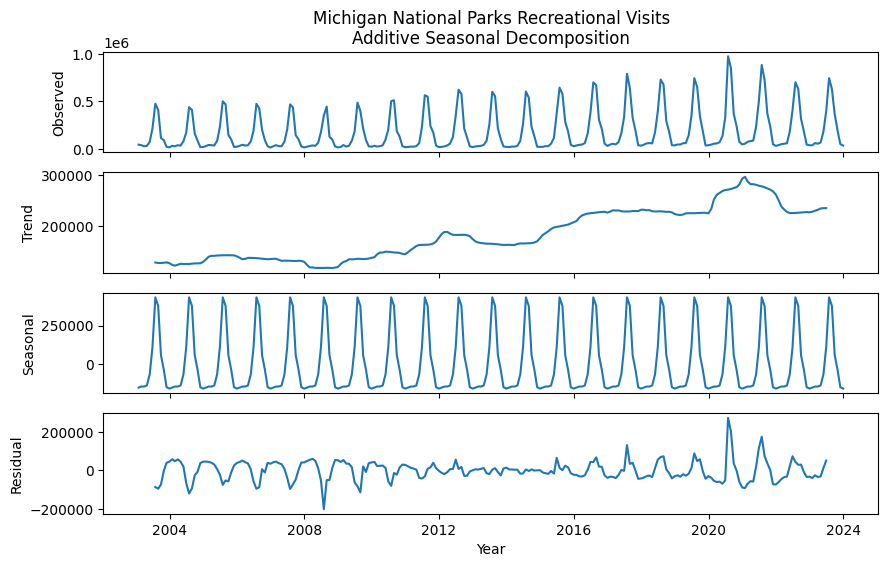

In [4]:
# MI rec visits as an example
state_agg_data=visit_data.groupby(['state_2','visit_type','date'])['number_of_visits'].sum().reset_index()
state_agg_data=state_agg_data[state_agg_data.visit_type=='RecreationVisits']
state_agg_data=state_agg_data.pivot(index='date',columns='state_2',values='number_of_visits')
state_agg_data.fillna(0,inplace=True)
state_agg_data.index = pd.to_datetime(state_agg_data.index, infer_datetime_format=True)
sea_decomp = seasonal_decompose(state_agg_data['MI'], model="additive",period=12) 
# 12 month period has the smoothest trend sign

# let's plot the seasonal decomposition

fig, axes = plt.subplots(4, 1, figsize=(10, 6), sharex=True)

axes[0].set_title("Additive Seasonal Decomposition")
axes[0].plot(sea_decomp.observed) # original/observed data
axes[0].set_ylabel("Observed")

axes[1].plot(sea_decomp.trend) # trend component
axes[1].set_ylabel("Trend")

axes[2].plot(sea_decomp.seasonal)
axes[2].set_ylabel("Seasonal") # seasonality component 

axes[3].plot(sea_decomp.resid) #  time series with the trend and seasonal components removed
axes[3].set_ylabel("Residual")

axes[3].set_xlabel("Year")
_=fig.suptitle("Michigan National Parks Recreational Visits", x=0.513, y=0.95)

In [5]:
def get_data_for_decomp(df:pd.DataFrame,column:str='RecreationVisits')-> pd.DataFrame:
    '''Formats the seasonal data in a better format
    Input:
        df
        column: string, type of visit data e.g. RecreationVisits
    Output:
        df'''
    state_agg_data=df.groupby(['state_2','visit_type','date'])['number_of_visits'].sum().reset_index()
    state_agg_data=state_agg_data[state_agg_data.visit_type==column]
    state_agg_data=state_agg_data.pivot(index='date',columns='state_2',values='number_of_visits')
    state_agg_data.fillna(0,inplace=True)
    state_agg_data.index = pd.to_datetime(state_agg_data.index, infer_datetime_format=True)
    return state_agg_data

def sea_decomp(df:pd.DataFrame)->pd.DataFrame:
    '''Extracts the seasonal & trend components of each column of a df.
    Input:
        df (pd.DataFrame): a df with a date time index, values are daily new cases

    Output:
        pd.DataFrame: each column has the seasonal component of a column.
    '''
    result = None
    for x in df.columns:
        sea_decomp = seasonal_decompose(df[x], model="additive",period=12)
        temp = pd.DataFrame(sea_decomp.seasonal)
        temp2 = pd.DataFrame(sea_decomp.trend)
        name = f'{x} seasonal'
        temp.columns = [name]
        temp2.columns = [f'{x} trend']
        if result is None: # for the first column
            result = temp.join(temp2)
        else:
            result = result.join(temp)
            result = result.join(temp2)
    return result

In [7]:
visit_data.visit_type.unique()

array(['RecreationVisits', 'NonRecreationVisits', 'RecreationHours',
       'NonRecreationHours', 'ConcessionerLodging', 'ConcessionerCamping',
       'TentCampers', 'RVCampers', 'Backcountry',
       'NonRecreationOvernightStays', 'MiscellaneousOvernightStays'],
      dtype=object)

In [43]:
# recreational visits
sea_comp_insert_data = get_data_for_decomp(visit_data,'RecreationVisits')
rec_seasonal_trend_dec =sea_decomp(sea_comp_insert_data)
rec_seasonal_trend_dec.columns = [x + ' recreational visits' for x in rec_seasonal_trend_dec]

# non recreational visits
sea_comp_insert_data = get_data_for_decomp(visit_data,'NonRecreationVisits')
nonrec_seasonal_trend_dec =sea_decomp(sea_comp_insert_data)
nonrec_seasonal_trend_dec.columns = [x + ' nonrecreational visits' for x in nonrec_seasonal_trend_dec]

# tent campers
sea_comp_insert_data = get_data_for_decomp(visit_data,'TentCampers')
tent_seasonal_trend_dec =sea_decomp(sea_comp_insert_data)
tent_seasonal_trend_dec.columns = [x + ' tent campers' for x in tent_seasonal_trend_dec]

# rv campers
sea_comp_insert_data = get_data_for_decomp(visit_data,'RVCampers')
rv_seasonal_trend_dec =sea_decomp(sea_comp_insert_data)
rv_seasonal_trend_dec.columns = [x + ' rv campers' for x in rv_seasonal_trend_dec]

# backcountry
sea_comp_insert_data = get_data_for_decomp(visit_data,'Backcountry')
bc_seasonal_trend_dec =sea_decomp(sea_comp_insert_data)
bc_seasonal_trend_dec.columns = [x + ' backcountry' for x in bc_seasonal_trend_dec]


# dictionary of dfs
breakdowns = {'recreational visits': rec_seasonal_trend_dec,
              'nonrecreational visits': nonrec_seasonal_trend_dec,
              'tent campers':tent_seasonal_trend_dec,
              'rv campers':rv_seasonal_trend_dec,
              'backcountry':bc_seasonal_trend_dec}

In [46]:
combined_df =rec_seasonal_trend_dec.merge(nonrec_seasonal_trend_dec,left_index=True, right_index=True).merge(tent_seasonal_trend_dec,left_index=True, right_index=True).merge(rv_seasonal_trend_dec,left_index=True, right_index=True).merge(bc_seasonal_trend_dec,left_index=True, right_index=True)
combined_df.reset_index(inplace=True)

In [49]:
# store all data
trend_seasonal = {}

# get all of the dataframes for each state
for state in visit_data.state_2.unique():
    # filter by state
    columns =[x for x in combined_df.columns if state in x]
    temp_df = combined_df[['date']+columns]
    # filter by trend & seasonal
    trend_columns =[x for x in temp_df.columns if 'trend' in x]
    seasonal_columns =[x for x in temp_df.columns if 'seasonal' in x]
    trend_df = temp_df[['date']+trend_columns].dropna() # dropping na because trend removes
    seasonal_df = temp_df[['date']+trend_columns]
    # save as dict
    trend_seasonal[state]={'trend_df':trend_df, 'seasonal_df':seasonal_df}

I will start by doing a sample ARIMA model on the state of Michigan for 2008.

In [93]:
mich_sample = get_data_for_decomp(visit_data,'RecreationVisits').reset_index()
mich_sample=mich_sample[mich_sample['date']<'2007-12-01']
best_model = auto_arima(mich_sample['MI'], start_p = 1, start_q = 1,
                          max_p = 12, max_q = 12, m = 12,
                          start_P = 0, seasonal = True,
                          d = None, D = 1, trace = True,
                          error_action ='ignore',   # we don't want to know if an order does not work
                          suppress_warnings = True,  # we don't want convergence warnings
                          stepwise = True)           # set to stepwise
best_model.fit(mich_sample['MI'])


Performing stepwise search to minimize aic
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=1087.706, Time=0.79 sec
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1088.431, Time=0.01 sec
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1084.009, Time=0.94 sec
Intel 

ARIMA(order=(0, 0, 0), scoring_args={}, seasonal_order=(2, 1, 0, 12),
      suppress_warnings=True)

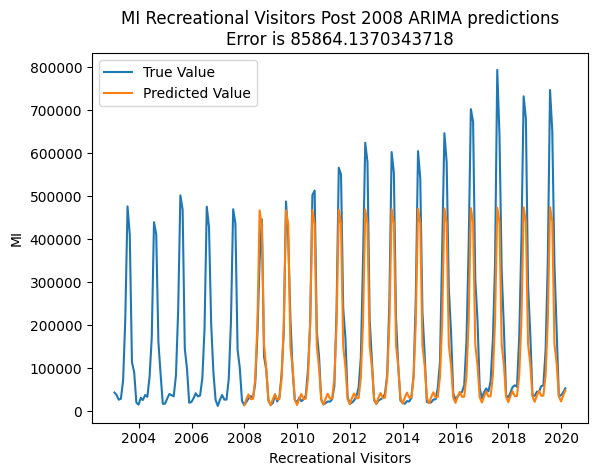

In [94]:
og_data = get_data_for_decomp(visit_data,'RecreationVisits').reset_index()
og_data = og_data[og_data['date']<'2020-03-01'] # before March
pred=og_data[og_data['date']>'2007-12-01']
resulted_val =best_model.predict(n_periods=len(pred))

error = np.sqrt(metrics.mean_squared_error(resulted_val,pred['MI']))
sns.lineplot(y=og_data['MI'],x=og_data['date'],label='True Value')
sns.lineplot(y=resulted_val,x=pred['date'],label='Predicted Value')
plt.xlabel('Recreational Visitors')
_ = plt.title(f'MI Recreational Visitors Post 2008 ARIMA predictions\nError is {error}')


In [107]:
def build_arima(df:pd.DataFrame, column:str,event:str='2008'):
    '''Build & eval an Arima Model for each state
    Input:
        df
        column
        event
    Output:
        dict: dictionary with error, predictions, and model
    '''
    if event=='2008': # filter data
        test = df[(df['date']<'2020-03-01') & (df['date']>'2007-12-01')][column]
        train = df[(df['date']<'2007-12-01')][column]
    elif event!='covid':
        print('Select either "covid" or "2008" for event.')
        return None
    else: # covid case
        test = df[(df['date']>'2020-03-01')][column]
        train = df[(df['date']>'2007-12-01')&(df['date']<'2020-03-01')][column]
    
    best_model = auto_arima(train, start_p = 1, start_q = 1,
                          max_p = 12, max_q = 12, m = 12,
                          start_P = 0, seasonal = True,
                          d = None, D = 1, trace = True,
                          error_action ='ignore',   # we don't want to know if an order does not work
                          suppress_warnings = True,  # we don't want convergence warnings
                          stepwise = True)           # set to stepwise
    # fit the model
    best_model.fit(train)
    # predict
    predictions = best_model.predict(n_periods=len(test))
    # get error
    rmse = np.sqrt(metrics.mean_squared_error(test,predictions))
    #
    return {'model':best_model,
            'error':rmse,
            'predictions':predictions,
            'test':test,
            'train':train,
            'stdev':test.std()} # also report std of time series as a reference for the scale
# RMSE divided by the stdev to normalize, divide after root

In [117]:
# took 81 minuts
arima_models_2008 = {}
arima_models_2020 = {}
og_data = get_data_for_decomp(visit_data,'RecreationVisits').reset_index()

for state in list(og_data.columns):
    if state=='date':
        continue
    print(state)
    arima_models_2008[state]=build_arima(og_data,state,event='2008')
    arima_models_2020[state]=build_arima(og_data,state,event='covid')

AK
Performing stepwise search to minimize aic
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=1091.672, Time=0.33 sec
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1086.589, Time=0.01 sec
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1089.918, Time=0.17 sec
Int

In [143]:
# maybe go back later and add a larger range for the models to run
error_dict = {}

for st in arima_models_2020.keys():
    # get best params
    best_params = arima_models_2020[st]['model'].get_params().get("order")
    # get error
    error = arima_models_2020[st]['error']
    # get stdev
    stdev = arima_models_2020[st]['stdev']
    # get standardized error
    std_error = error/stdev
    # update dict
    error_dict[st] = [best_params,error,stdev,std_error]

arima_2020_error_df =pd.DataFrame.from_dict(error_dict,orient='index')
arima_2020_error_df.columns = ['best_params','error','stdev','std_error']

,best_params,error,stdev,std_error
AK,"(1, 0, 0)",261006.331093,211642.394600,1.233242
AL,"(1, 1, 0)",18216.495098,23045.497165,0.790458
AR,"(1, 0, 1)",99003.246180,164926.396065,0.600287
AS,"(1, 0, 1)",4118.515208,662.495127,6.216672
AZ,"(1, 0, 0)",367377.309533,182489.113444,2.013146


In [186]:
# ARIMA Models with the best fit for 2008
best_fit_2020 = arima_2020_error_df.sort_values(by='std_error').head(5)
best_fit_2020

,best_params,error,stdev,std_error
MI,"(2, 0, 0)",60243.939271,270955.148128,0.222339
SD,"(2, 0, 0)",80650.221130,349213.228627,0.230948
NE,"(1, 0, 0)",4765.905437,20527.112685,0.232176
ND,"(1, 0, 0)",14370.957026,61607.823219,0.233265
ME,"(1, 0, 0)",78469.730367,301244.211382,0.260485


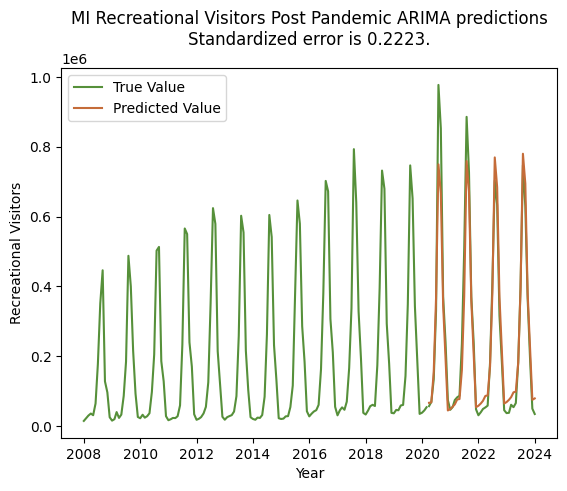

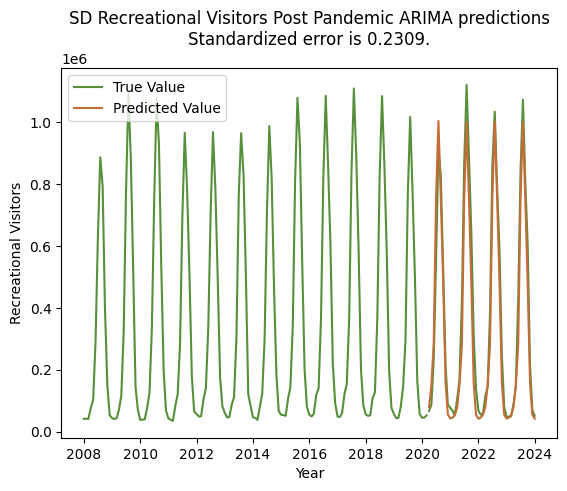

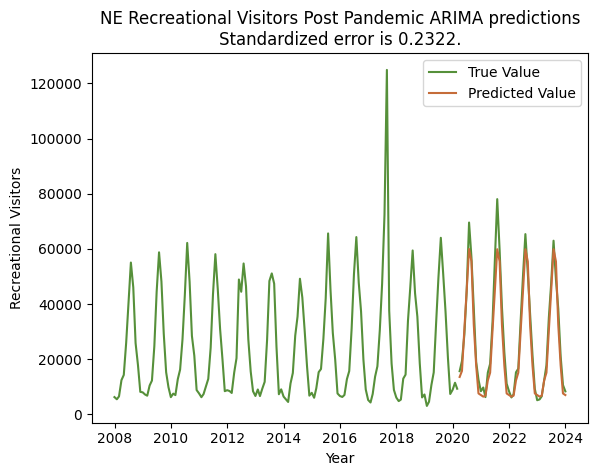

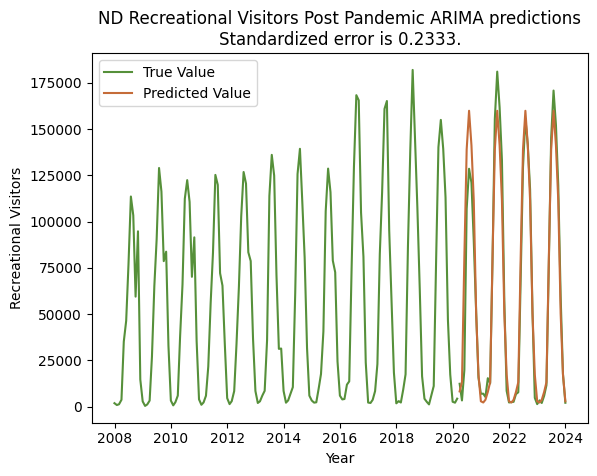

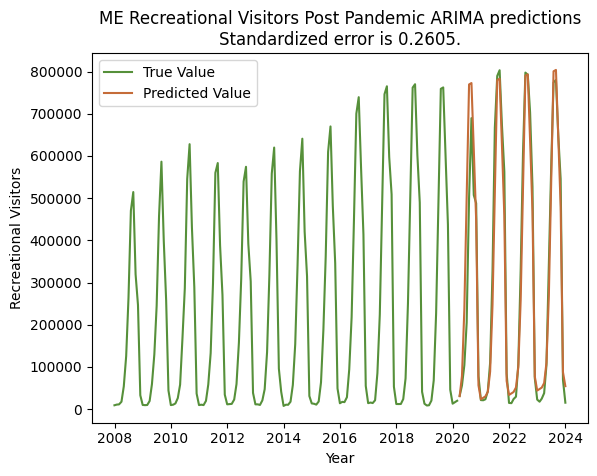

In [216]:
# ARIMA Models with the best fit for 2020

# get the date range
df = og_data
test = df[(df['date']>'2020-03-01')]['date']
train = df[(df['date']>'2007-12-01')&(df['date']<'2020-03-01')]['date']

# create plots
for x in best_fit_2020.index:
    arima_models_2008
    sns.lineplot(y=arima_models_2020[x]['train'],x=train,label='True Value',color='#56903A')
    sns.lineplot(y=arima_models_2020[x]['test'],x=test,color='#56903A')
    sns.lineplot(y=arima_models_2020[x]['predictions'].values,x=test,label='Predicted Value',color='#C56C39')
    plt.ylabel('Recreational Visitors')
    plt.xlabel('Year')
    plt.title(f'{x} Recreational Visitors Post Pandemic ARIMA predictions\nStandardized error is {round(best_fit_2020.loc[x].std_error,4)}.')
    plt.show()

The states with best performing ARIMA Models pre/post Covid-19 outbreak were MI, SD, NE, ND, and ME.

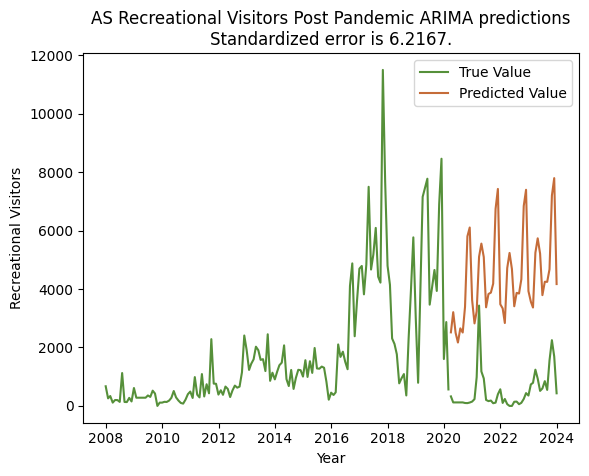

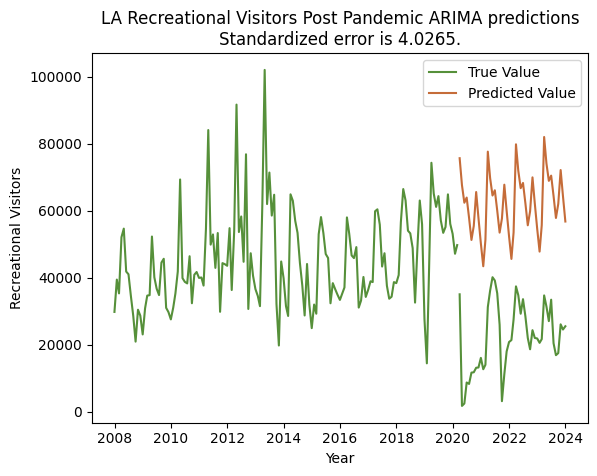

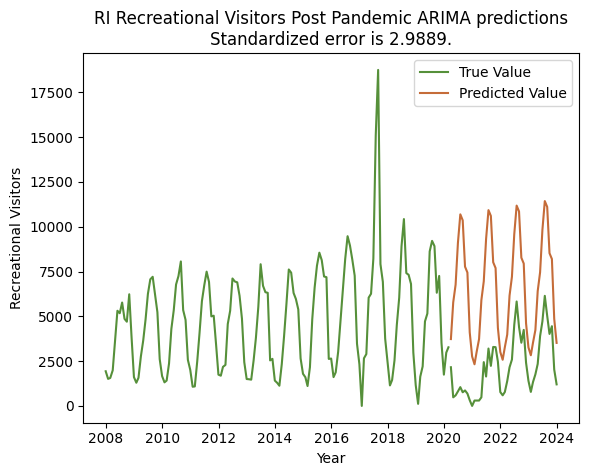

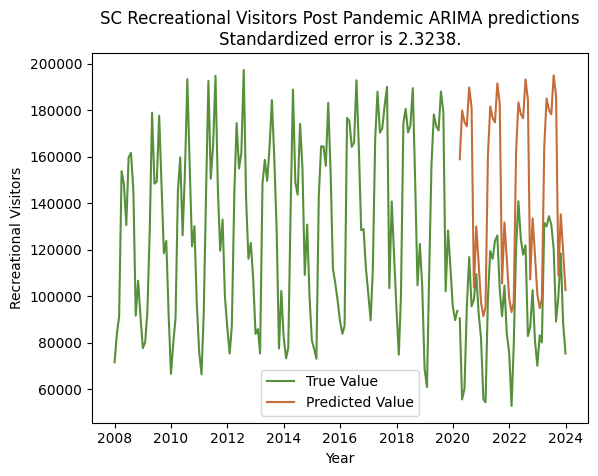

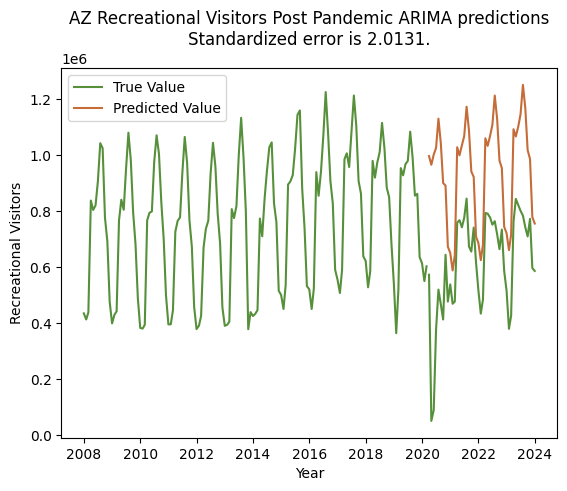

In [217]:
# ARIMA Models with the worst fit for 2020
worst_fit_2020=arima_2020_error_df.sort_values(by='std_error',ascending=False).head(5)

for x in worst_fit_2020.index:
    sns.lineplot(y=arima_models_2020[x]['train'],x=train,label='True Value',color='#56903A')
    sns.lineplot(y=arima_models_2020[x]['test'],x=test,color='#56903A')
    sns.lineplot(y=arima_models_2020[x]['predictions'].values,x=test,label='Predicted Value',color='#C56C39')
    plt.ylabel('Recreational Visitors')
    plt.xlabel('Year')
    plt.title(f'{x} Recreational Visitors Post Pandemic ARIMA predictions\nStandardized error is {round(worst_fit_2020.loc[x].std_error,4)}.')
    plt.show()

In [149]:
# maybe go back later and add a larger range for the models to run
error_dict_2008 = {}

for st in arima_models_2008.keys():
    # get best params
    best_params = arima_models_2008[st]['model'].get_params().get("order")
    # get error
    error = arima_models_2008[st]['error']
    # get stdev
    stdev = arima_models_2008[st]['stdev']
    # get standardized error
    std_error = error/stdev
    # update dict
    error_dict_2008[st] = [best_params,error,stdev,std_error]

arima_2008_error_df =pd.DataFrame.from_dict(error_dict_2008,orient='index')
arima_2008_error_df.columns = ['best_params','error','stdev','std_error']

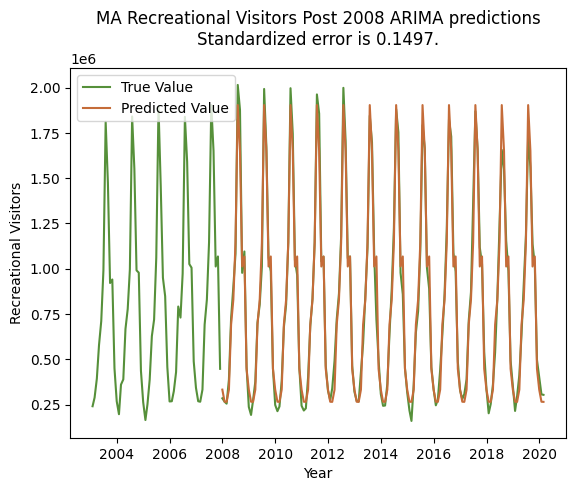

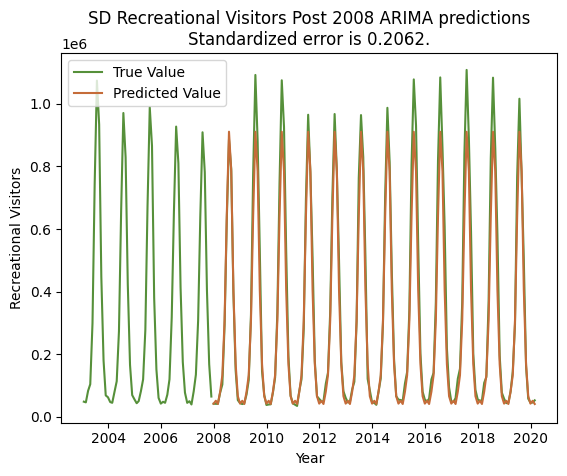

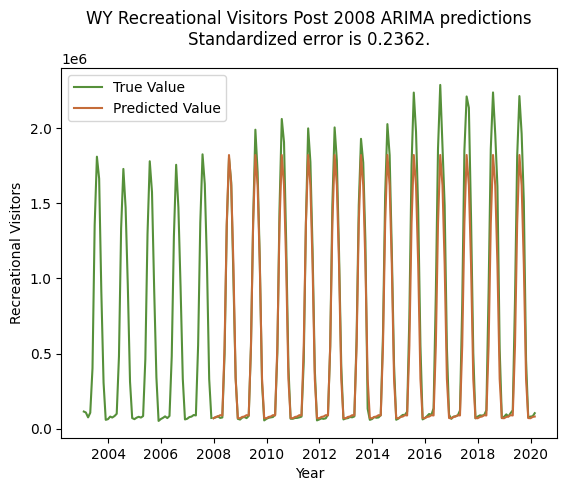

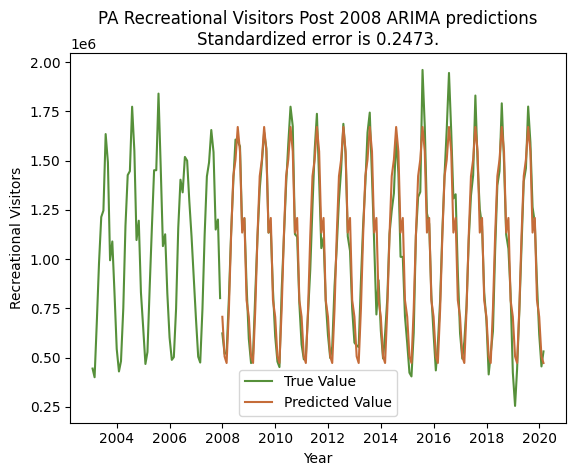

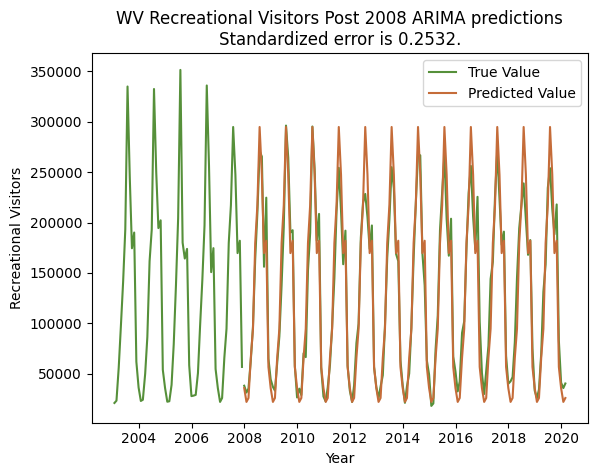

In [193]:
# ARIMA Models with the best fit for 2008
# sort the errors
best_fit_2008 = arima_2008_error_df.sort_values(by='std_error').head(5)

# get the date range
df = og_data
test = df[(df['date']<'2020-03-01') & (df['date']>'2007-12-01')]['date']
train = df[(df['date']<'2007-12-01')]['date']

# create plots
for x in best_fit_2008.index:
    arima_models_2008
    sns.lineplot(y=arima_models_2008[x]['train'],x=train,label='True Value',color='#56903A')
    sns.lineplot(y=arima_models_2008[x]['test'],x=test,color='#56903A')
    sns.lineplot(y=arima_models_2008[x]['predictions'],x=test,label='Predicted Value',color='#C56C39')
    plt.ylabel('Recreational Visitors')
    plt.xlabel('Year')
    plt.title(f'{x} Recreational Visitors Post 2008 ARIMA predictions\nStandardized error is {round(best_fit_2008.loc[x].std_error,4)}.')
    plt.show()

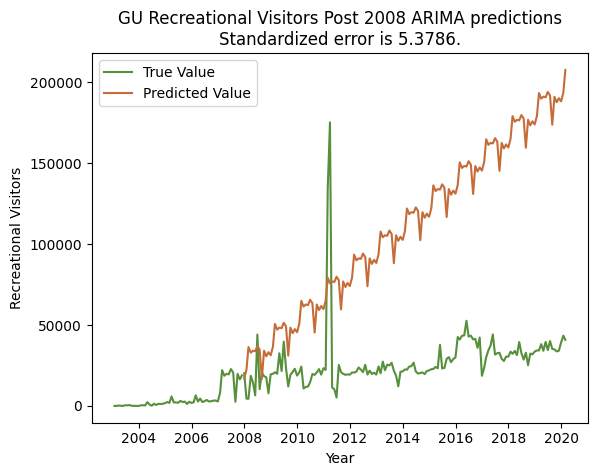

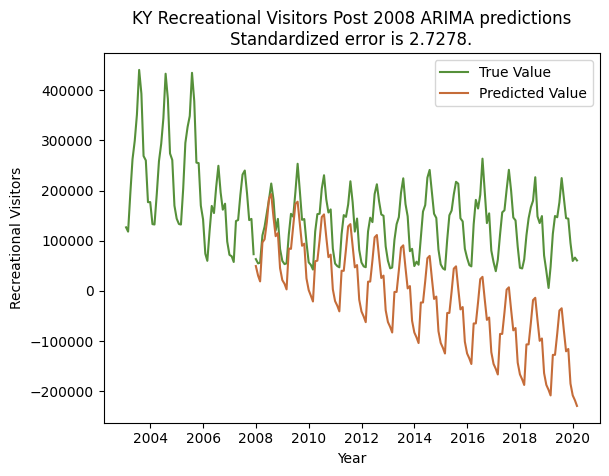

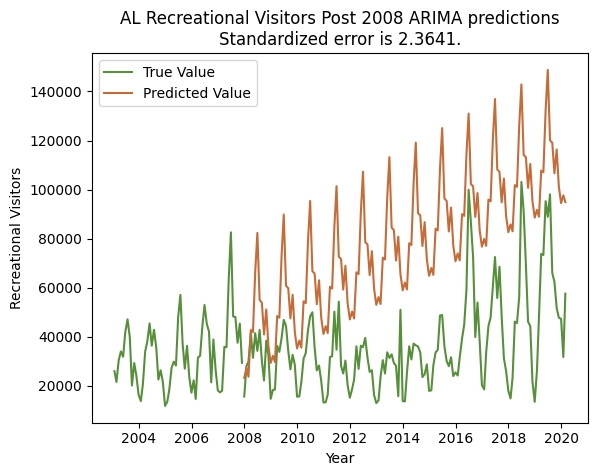

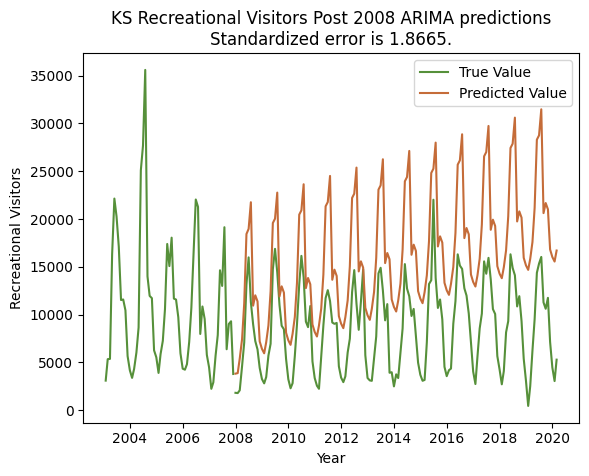

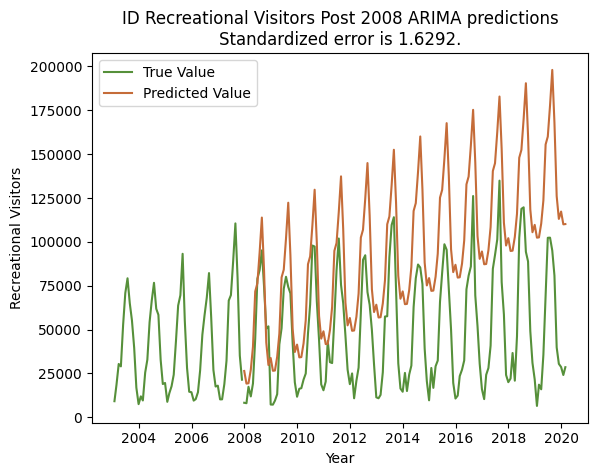

In [194]:
# ARIMA Models with the worst fit for 2008
worst_fit_2008=arima_2008_error_df.sort_values(by='std_error',ascending=False).head(5)

# create plots
for x in worst_fit_2008.index:
    sns.lineplot(y=arima_models_2008[x]['train'],x=train,label='True Value',color='#56903A')
    sns.lineplot(y=arima_models_2008[x]['test'],x=test,color='#56903A')
    sns.lineplot(y=arima_models_2008[x]['predictions'],x=test,label='Predicted Value',color='#C56C39')
    plt.ylabel('Recreational Visitors')
    plt.xlabel('Year')
    plt.title(f'{x} Recreational Visitors Post 2008 ARIMA predictions\nStandardized error is {round(worst_fit_2008.loc[x].std_error,4)}.')
    plt.show()

# Using exogenous data, we want to see if search data for different terms will help create better models

In this part, we will execute Granger Causality to see if Google Search Data for different terms will help the model performance. We will use this as a proxy for public sentiment about the different terms.

In [238]:
# load the data
recession_search = pd.read_csv('recession.csv') # month not day
bestnp_search = pd.read_csv('bestnp_query.csv') # month not day
np_search = pd.read_csv('nationalparks_query.csv') # month not day
covid_search = pd.read_csv('covid19_query.csv') # day values

In [244]:
# turn the months into days, similar to how we did the NP data
def get_month_date(df):
    month_to_day = {1:31,2:28,3:31,4:30,5:31,6:30,7:31,8:31,9:30,10:31,11:30,12:31}
    df['year']=df['Month'].apply(lambda x: x.split('-')[0])
    df['month']=df['Month'].apply(lambda x: int(x.split('-')[1]))
    df['day'] = df['month'].apply(lambda x: month_to_day[x])
    df['date']=pd.to_datetime(df[['year','month','day']])
    return df

recession_search=get_month_date(recession_search)
bestnp_search=get_month_date(bestnp_search)
np_search=get_month_date(np_search)

In [250]:
# renaming columns for convenience
recession_search.columns=['Month', 'recession', 'year', 'month', 'day', 'date']
bestnp_search.columns=['Month', 'bestnp','year', 'month', 'day', 'date']
np_search.columns=['Month', 'np','year', 'month', 'day', 'date']
covid_search.columns=['date', 'covid']

In [252]:
# putting all data in one dict for iteration
search_dict = {'recession':recession_search, 'bestnp':bestnp_search,'np':np_search,'covid':covid_search}

Now that our data is in a better format, we can try a modified version of the ARIMA functions from above, but where we introduce an exogenous variable (the search data!). One interesting challenge is that they all have different date ranges

I want to start by walking through one example.

In [276]:
min_date = np_search['date'].min()
max_date = np_search['date'].max()

data = get_data_for_decomp(visit_data,'RecreationVisits').reset_index()
# filter data by the time included in the exog sample
data_filtered = data[(data.date >= min_date)&(data.date <= max_date)]
# now split into test & train, let's do the 2008 dates
train = data_filtered[data_filtered.date<'2007-12-01'][['MI','date']]
test = data_filtered[(data_filtered.date>'2007-12-01')&(data_filtered['date']<'2020-03-01')][['MI','date']]
train = train.merge(np_search[['date','np']],on='date')
test = test.merge(np_search[['date','np']],on='date')

# grid search model
best_model = auto_arima(X=train[['np']],y=train['MI'], start_p = 1, start_q = 1,
                          max_p = 12, max_q = 12, m = 12,
                          start_P = 0, seasonal = True,
                          max_d=12, D = 1, trace = True,
                          error_action ='ignore',   # we don't want to know if an order does not work
                          suppress_warnings = True,  # we don't want convergence warnings
                          stepwise = True)           # set to stepwise
# fit model
best_model.fit(X=train[['np']],y=train['MI'])

# predict
preds = best_model.predict(X=test[['np']],n_periods=len(test['np']))

# plot


Performing stepwise search to minimize aic
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=811.124, Time=0.72 sec
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=815.520, Time=0.02 sec
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=810.991, Time=0.24 sec
Intel MKL

ARIMA(order=(0, 0, 0), scoring_args={}, seasonal_order=(0, 1, 2, 12),
      suppress_warnings=True, with_intercept=False)

In [291]:
preds = best_model.predict(X=test[['np']],n_periods=len(test['np']))

<Axes: xlabel='date', ylabel='MI'>

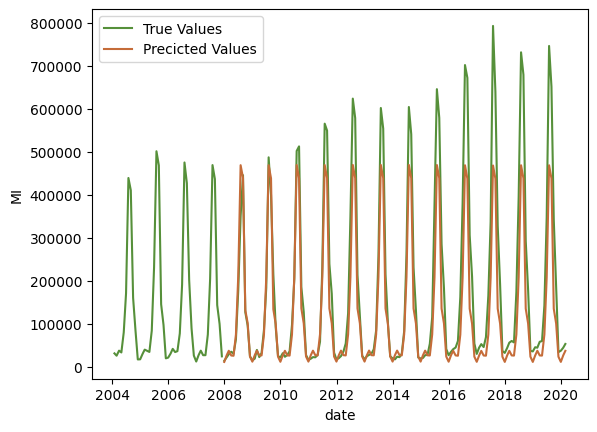

In [294]:
sns.lineplot(x=train['date'],y=train['MI'],label='True Values')
sns.lineplot(x=test['date'],y=test['MI'],color=palette[0])
sns.lineplot(x=test['date'],y=preds.values,color=palette[1],label='Precicted Values')